In [2]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
%matplotlib inline

pd.options.display.max_columns = 100

In [3]:
from secret import local_config

# Propub Specific Vote Data

In [4]:
conn = sqlite3.connect(local_config.db_params['database'])
df_voters = pd.read_sql_query('SELECT * from {}'.format(
    local_config.db_params['table_individual_votes']), conn)
df_overview = pd.read_sql_query('SELECT * from {}'.format(
    local_config.db_params['table_overview']), conn)
conn.close()
del df_overview['index']
del df_voters['index']

In [5]:
full = df_voters.merge(df_overview, on=['congress','session','roll_call'])

In [6]:
full['republican_total'] = full['republican_yes'] + full['republican_no'] + full['republican_not_voting']
full['democratic_total'] = full['democratic_yes'] + full['democratic_no'] + full['democratic_not_voting']
full['independent_total'] = full['independent_yes'] + full['independent_no'] + full['independent_not_voting']
full['total'] = full[['republican_total','democratic_total','independent_total']].sum(axis=1)
full['total_yes'] = full['republican_yes'] +full['democratic_yes'] +full['independent_yes']
full['republican_per_yes'] = full['republican_yes']/full['republican_total']
full['democratic_per_yes'] = full['democratic_yes']/full['democratic_total']
full['total_per_yes'] = full['total_yes']/full['total']

In [7]:
full['congress_id'] = full['congress'] + (full['session']-1)/2

In [8]:
"""The further from zero the value the more partisan the closer to 0 the less 
(more cross isle balance)"""
full['partisan_weight'] = (
    (full['democratic_per_yes']-full['republican_per_yes'])/
                    full['total_per_yes']
)

In [9]:
def fix_vote_type(vote_type):
    try:
        numer, denom = vote_type.split('/')
        perct = float(numer)/float(denom)*100
    except:
        perct = vote_type
    finally:
        if perct == 50:
            return 51
        else:
            return np.round(perct,0).astype(int)

full['vote_type'] = full['vote_type'].map(fix_vote_type)

In [10]:
full['yes_needed'] = (full['vote_type']/100)*full['total']
full['pass'] = np.where(full['total_yes']>full['yes_needed'],True,False)

In [11]:
full['vote_position'] = full['vote_position'].replace(
    'Yes', 1).replace(
    'No', -1).replace(
    'Not Voting', 0).replace(
    'Present', 0)

In [12]:
full['vote_partisonship'] = full['vote_position']*full['partisan_weight']

In [13]:
agg_method = {'vote_position':'sum',
              'democratic_no':'sum',
              'democratic_yes':'sum',
              'republican_no':'sum',
              'republican_yes':'sum',
              'independent_yes':'sum',
              'independent_no':'sum',
              'vote_partisonship':['mean','median','std'],
              'partisan_weight':'sum',
              'democratic_present':'count',
              'party':'first'}

# States
___
## Overall

In [13]:
state = full.groupby(
    ['state']).agg(agg_method
    ).rename(columns={'democratic_present':'votes'})

state_colors = {'R':'red',
                'D':'blue',
                'I':'yellow',
                'ID':'pink'}

state.sort_values(('vote_partisonship','mean'),inplace=True)

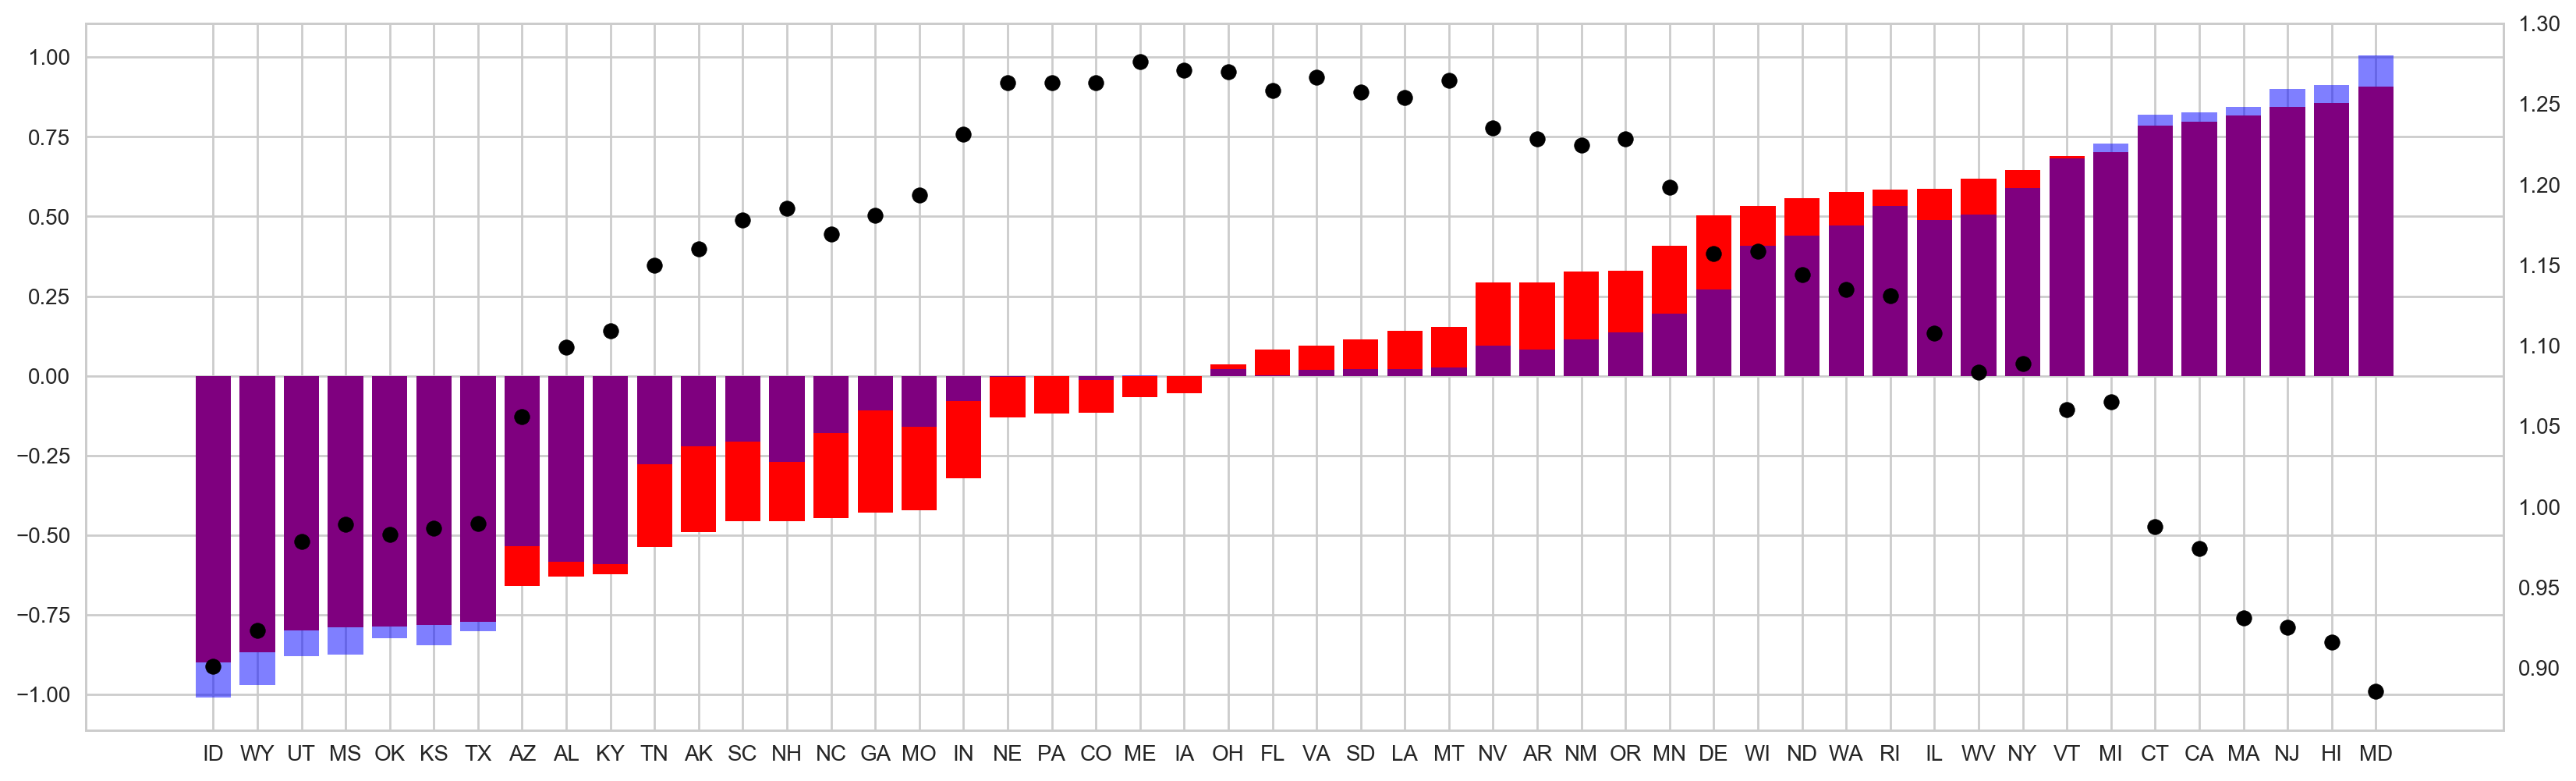

In [14]:
sns.set_context('notebook')
sns.set_style('whitegrid')
sns.set_palette(sns.color_palette("muted"))
X = state.reset_index().index
Y = state['vote_partisonship']['mean']
Y2 = state['vote_partisonship']['median']
Y3 = state['vote_partisonship']['std']


fig, ax1 = plt.subplots(figsize=(20,6),dpi=200)
ax1.bar(X,Y, color = 'red')
ax1.bar(X,Y2, color='blue',alpha=.5)
ax1.set_xticks(range(50))
ax2 = ax1.twinx()
ax2.scatter(X,Y3, color='black')
ax2.grid(False)

ax1.set_xticklabels(state.index.tolist())
# ax1.axhline(y=0, ls='--', lw=1, c='black')
plt.show()

## Over Time

In [15]:
state_senate = full.groupby(
    ['congress_id','state']).agg(agg_method
    ).rename(columns={'democratic_present':'votes'})

state_colors = {'R':'red',
                'D':'blue',
                'I':'yellow',
                'ID':'pink'}

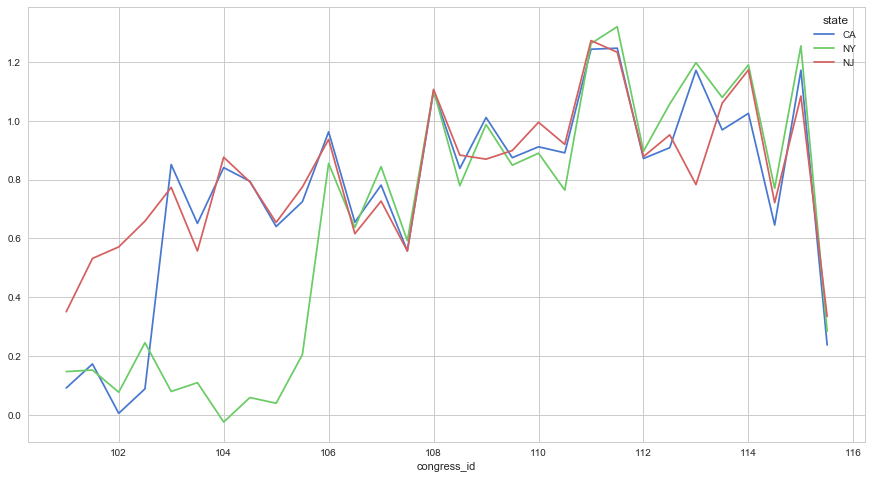

In [16]:
state_senate.unstack(level=[0])['vote_partisonship']['mean'].T[['CA','NY','NJ']].plot(figsize=(15,8))

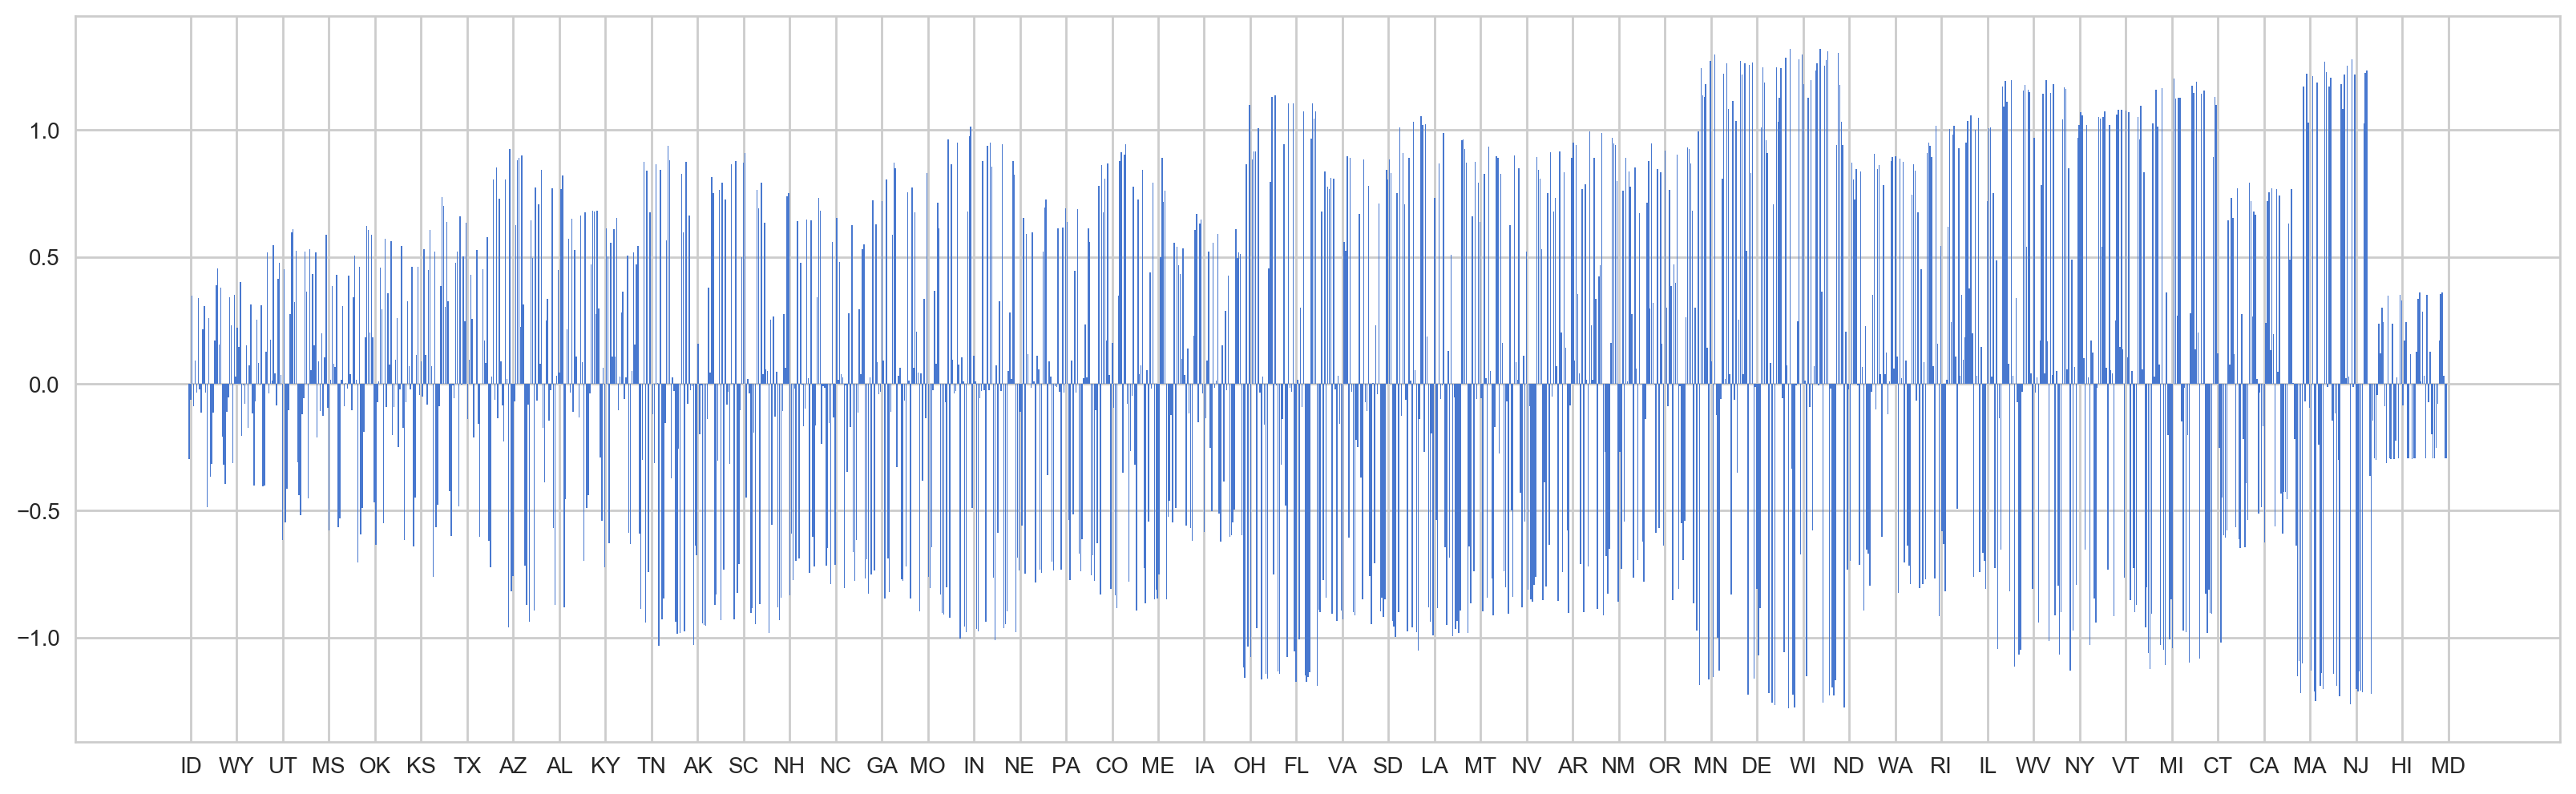

In [17]:
sns.set_context('notebook')
sns.set_style('whitegrid')
sns.set_palette(sns.color_palette("muted"))
X = state_senate.reset_index().index
Y = state_senate['vote_partisonship']['mean']


fig, ax1 = plt.subplots(figsize=(20,6),dpi=200)
ax1.bar(X,Y)

ax1.set_xticks(np.linspace(1,len(X),50))
ax1.set_xticklabels(state.index.tolist())
# ax1.axhline(y=0, ls='--', lw=1, c='black')
plt.show()

## Middle States

In [18]:
middle_states = state[np.abs(state['vote_partisonship']['mean']) < .2].index.tolist()
high_std = state[state[('vote_partisonship','std')] > state.describe()['vote_partisonship']['std']['75%']].index.tolist()
print(' | '.join(middle_states))
print(' | '.join(high_std))

NE | PA | CO | ME | IA | OH | FL | VA | SD | LA | MT
IN | NE | PA | CO | ME | IA | OH | FL | VA | SD | LA | MT | NV


In [19]:
mid_state_senate = full[full['state'].isin( high_std)]

mid_state_senate = full.groupby(
    ['state','congress_id']).agg(agg_method
    ).rename(columns={'democratic_present':'votes'})

state_colors = {'R':'red',
                'D':'blue',
                'I':'yellow',
                'ID':'pink'}

In [20]:
state_senate.unstack(level=[0])['vote_partisonship']['mean'][middle_states].plot(figsize=(30,16))

KeyError: "[u'NE' u'PA' u'CO' u'ME' u'IA' u'OH' u'FL' u'VA' u'SD' u'LA' u'MT'] not in index"

# People

In [21]:
member_senate = full.groupby(
    ['congress_id','member_id']).agg(agg_method
    ).rename(columns={'democratic_present':'votes'})


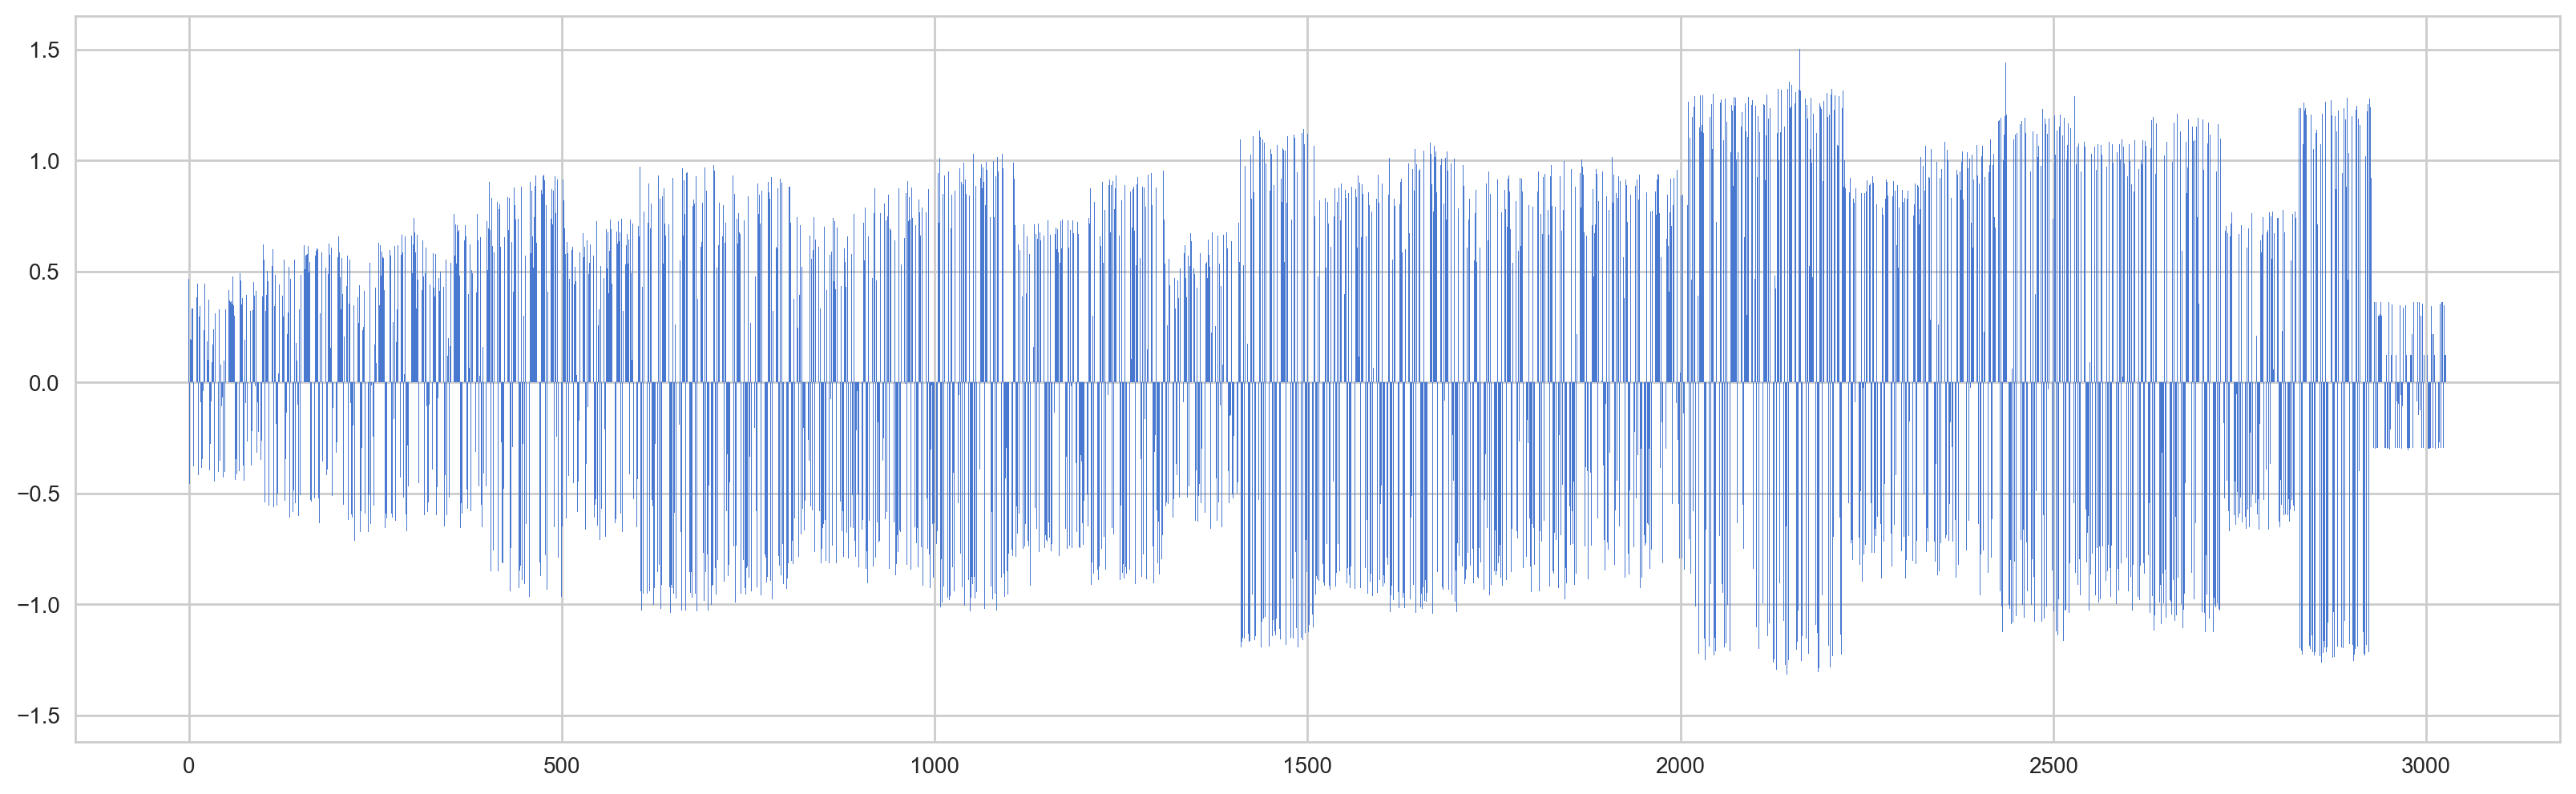

In [22]:
sns.set_context('notebook')
sns.set_style('whitegrid')
sns.set_palette(sns.color_palette("muted"))
X = member_senate.reset_index().index
Y = member_senate['vote_partisonship']['mean']


fig, ax1 = plt.subplots(figsize=(20,6),dpi=200)
ax1.bar(X,Y)
# ax1.axhline(y=0, ls='--', lw=1, c='black')
plt.show()

## Bills

In [23]:
bill_removal = [str(bill) for bill in np.arange(-120,-100).tolist()]

bill = full[~full['bill_id'].isin(bill_removal)].groupby(['bill_id']).agg(agg_method).rename(columns={'democratic_present':'votes'})

ValueError: x and y must be the same size

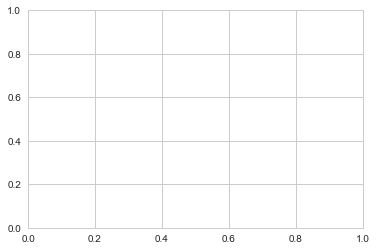

In [24]:
fig, ax1 = plt.subplots()
ax1.scatter(bill['votes'],bill['vote_partisonship'])

In [ ]:
def partisan_model(d,r):
    return np.abs(((d/(d+r))-.5)*2)
df_overview_ = df_overview.dropna(subset=['democratic_yes','republican_yes']).head(1000)
X = df_overview_['democratic_yes']
Y = df_overview_['republican_yes']
X, Y = np.meshgrid(X, Y)
Z = partisan_model(X,Y)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf = ax.scatter(X, Y, Z, alpha =.01)
ax.set_xlabel('Democratic Yes Votes')
ax.set_ylabel('Republican Yes Votes')
ax.set_zlabel('Partisanship')

# Overview

In [1]:
df_overview['republican_total'] = df_overview['republican_yes'] + df_overview['republican_no'] + df_overview['republican_not_voting']
df_overview['democratic_total'] = df_overview['democratic_yes'] + df_overview['democratic_no'] + df_overview['democratic_not_voting']
df_overview['independent_total'] = df_overview['independent_yes'] + df_overview['independent_no'] + df_overview['independent_not_voting']
df_overview['total'] = df_overview[['republican_total','democratic_total','independent_total']].sum(axis=1)
df_overview['republican_per_yes'] = df_overview['republican_yes']/df_overview['republican_total']
df_overview['democratic_per_yes'] = df_overview['democratic_yes']/df_overview['democratic_total']
df_overview['total_per_yes'] = df_overview['total_yes']/df_overview['total']

NameError: name 'df_overview' is not defined

In [ ]:
df_overview['partisan_weight'] = (
    (df_overview['democratic_per_yes']-df_overview['republican_per_yes'])/
                       df_overview['total_per_yes']
)

In [ ]:
df_overview['party_vote'] = np.where(df_overview['democratic_per_yes'] - .1 > df_overview['republican_per_yes'],
                                     1,np.where(df_overview['republican_per_yes'] - .1 > df_overview['democratic_per_yes'],-1,0))

In [ ]:
bill_color = {1:'blue',0:'green',-1:'red'}

In [ ]:
bill_removal = [str(bill) for bill in np.arange(-120,-100).tolist()]

bill = df_overview[(~df_overview['bill_id'].isin(bill_removal)) & (df_overview['partisan_weight'] < 2)]
bill = bill.sort_values(['congress','session','roll_call'])
bill = bill.reset_index()
del bill['index']

In [ ]:
fig, ax1 = plt.subplots()

ax1.scatter(bill.index.tolist(), bill['partisan_weight'], c=bill['party_vote'].map(bill_color), s=5)

# around

In [ ]:
full.groupby('member_id').sum()

# GIS Plots

In [15]:
import geopandas as gpd

In [24]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world['gdp_per_cap'] = world.gdp_md_est / world.pop_est

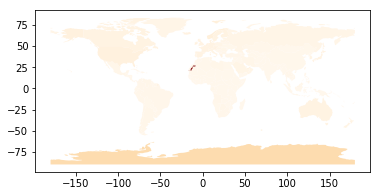

In [28]:
world.plot(column='gdp_per_cap', cmap='OrRd')

In [ ]:
!conda install pysal

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.4.10
  latest version: 4.5.0

Please update conda by running

    $ conda update -n base conda



## Package Plan ##

  environment location: /Users/ryand/anaconda2

  added / updated specs: 
    - pysal


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2018.1.18          |           py27_0         143 KB  conda-forge
    pysal-1.14.3               |           py27_0        14.9 MB  conda-forge
    ------------------------------------------------------------
                                           Total:        15.0 MB

The following NEW packages will be INSTALLED:

    pysal:   1.14.3-py27_0    conda-forge

The following packages will be UPDATED:

    certifi: 2018.1.18-py27_0             --> 2018.1.18-py27_0 conda-forge

Proceed ([y]/n)? 